In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the dashboard


# Overview

In this notebook I have created a dashboard giving an overview of the problems in Zürich. The map shows the location of all problems, what the problem is and the status of the problem. The user can filter by the type of problem, to see only the problems of interest, e.g. only the problems with the type "Graffiti" that are still open.

### Why?/Usecases

Citizens can use this dashboard to see what problems there are in Zurich, to stay up to date.

If a citizen is planning a late picnic in Irchel Park, they can check the dashboard to see if there are any problems in the park, e.g.:

if the lighting is broken, they might have to bright a lamp themselves.
there was one (albeit erroneous) report of a type of mosquito that can carry the dangerous Dengue fever, so they might want to choose a different park.


Benevolent citizens can filter by cases of graffiti that are not fixed yet and clean it up themselves.

If you are moving to Wiedikon and don't know much about the area, you can check the dashboard to see what problems there are in the area, and if they are being fixed.


For the people behind "Zurich wie neu", this dashboard could maybe offer a different overview of the city's problems.


### Data

This data set is from "Zurich wie neu" (Zurich like new), a program where citizens can report problems or flaws in the city. Stadt Zurich will then respond to the report and ideally fix the problem.

The (important) columns in the data set are:

coordinates (e,n): the coordinates of the problem in Swiss (east, north) format

service_code: the type of problem in 10 categories

status: the status of the problem

requested_datetime: the date and time the problem was reported

updated_datetime: the date and time the problem was updated. If updated to "fixed" it indicates the time it took to fix the problem.

detail: a description of the problem from the citizen

media_url: a link to a picture of the problem uploaded by the citizen


### Analysis

The goal is to find some interesting insights in the data set and put it into a dashboard. The dashboard will be created using Plotly Dash.

### Dashboard Goals

The dashboard should:

Have a map of Zurich with the problems marked on it. The user should be able to select a problem and see the type, status, and when it was reported and updated.

Have a dropdown menu to filter by the type of problem.



## Inspect data

In [2]:
data_raw = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/ZWN_data/data/stzh_zwn_meldungen_p.csv')

data_raw.head()

,objectid,service_request_id,e,n,service_code,status,detail,media_url,interface_used,requested_datetime,agency_sent_datetime,updated_datetime,service_notice,title,description,service_name,url,geometry
0,1,1,2678968.0,1247548.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Asphalt des Bürgersteigs hat es eine E...,NaN,Web interface,20130314151615,2.013040e+13,20130412075930,Diese Reparatur wird von uns in den kommenden ...,Auf dem Asp,Auf dem Asp: Auf dem Asphalt des Bürgersteigs ...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/1,POINT (2678968 1247548)
1,2,2,2680746.0,1249916.0,Strasse/Trottoir/Platz,fixed - council,Vermessungspunkt ist nicht mehr bündig mit dem...,NaN,Web interface,20130314151757,2.013033e+13,20130412080022,Diese Reparatur wird von uns in den kommenden ...,Vermessungs,Vermessungs: Vermessungspunkt ist nicht mehr b...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/2,POINT (2680746 1249916)
2,3,4,2684605.0,1251431.0,Strasse/Trottoir/Platz,fixed - council,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Web interface,20130315091416,2.013032e+13,20130412080810,Diese Reparatur wird von uns in den kommenden ...,Beim Trotto,Beim Trotto: Beim Trottoir sind einige Randste...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/4,POINT (2684605 1251431)
3,4,5,2681754.0,1250376.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Web interface,20130315091715,2.013032e+13,20130412080905,Diese Reparatur wird von uns in den kommenden ...,Auf dem Par,Auf dem Par: Auf dem Parkplatz beim Waidspital...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/5,POINT (2681754 1250376)
4,5,6,2683094.0,1247762.0,Abfall/Sammelstelle,fixed - council,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Web interface,20130315103653,2.013042e+13,20130423135033,Dieses Graffiti wird von uns in den kommenden ...,Arbeitskist,Arbeitskist: Arbeitskiste ist rund herum versc...,Abfall/Sammelstelle,https://www.zueriwieneu.ch/report/6,POINT (2683094 1247762)


## Data preprocessing

In [3]:
# Remove duplicate column
(data_raw['service_name'] == data_raw['service_code']).all()
data = data_raw.drop('service_code', axis=1)

#Fill NaNs in messages
data['service_notice'].fillna('No response to report.', inplace=True)
data['detail'].fillna('No message in report.', inplace=True)

In [4]:
# Convert timestamp to datetime format
date_columns = ['requested_datetime', 'agency_sent_datetime', 'updated_datetime']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], format='%Y%m%d%H%M%S')

data[date_columns]

,requested_datetime,agency_sent_datetime,updated_datetime
0,2013-03-14 15:16:15,2013-04-04 07:25:05,2013-04-12 07:59:30
1,2013-03-14 15:17:57,2013-03-26 14:05:05,2013-04-12 08:00:22
2,2013-03-15 09:14:16,2013-03-15 09:55:05,2013-04-12 08:08:10
3,2013-03-15 09:17:15,2013-03-20 10:05:05,2013-04-12 08:09:05
4,2013-03-15 10:36:53,2013-04-22 18:25:05,2013-04-23 13:50:33
...,...,...,...
54140,2024-09-04 16:29:01,2024-09-04 16:32:05,2024-09-04 19:00:15
54141,2024-09-04 16:43:28,2024-09-04 16:47:04,2024-09-04 19:14:00
54142,2024-09-04 16:46:14,2024-09-04 17:22:04,2024-09-04 17:22:04
54143,2024-09-04 16:51:49,2024-09-04 16:52:05,2024-09-04 16:53:07


In [5]:
data['media_url'].fillna('No media', inplace=True)

In [43]:
# Add time it took to fix the problem
data[data['status'] == 'fixed - council'][['requested_datetime', 'updated_datetime']]
data.loc[:,'service_time'] = np.zeros(data.shape[0])
data.loc[:,'service_time'] = data['updated_datetime'] - data['requested_datetime']
data.loc[:,'service_time'] = data['service_time'].dt.total_seconds() / 60 / 60
# Add report_day as a column
data.loc[:,'report_month'] = data.loc[:,'requested_datetime'].dt.month
# Add report_year
data.loc[:,'report_year'] = data.loc[:,'requested_datetime'].dt.year

# Ensure years and weekdays are ordered for plotting later
years = sorted(data['requested_datetime'].dt.year.unique())
months = sorted(data['requested_datetime'].dt.month.unique())#, key=lambda x: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'].index(x))
#weekdays = sorted(data['requested_datetime'].dt.day_name().unique(), key=lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x))


C:\Users\simon\AppData\Local\Temp\ipykernel_14968\1423449726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Converting the coordinates from the swiss east and north format to latitude and longitude.

In [44]:
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)


# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


C:\Users\simon\AppData\Local\Temp\ipykernel_14968\1973745879.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
'1d1d<br/>'.replace('<br/>','\n')

'1d1d\n'

In [46]:
# Clean up SZ answers to reports
# clean text in service_note

data.loc[:,'service_notice'] = [msg.replace('<br/>', '\n ') for msg in data.loc[:,'service_notice'].values]
data.loc[:,'detail']         = [msg.replace('<br/>', '\n ') for msg in data.loc[:,'detail'].values]

data

,objectid,service_request_id,e,n,status,detail,media_url,interface_used,requested_datetime,agency_sent_datetime,...,url,geometry,service_time,report_day,report_year,longitude,latitude,point,kreis_name,report_month
0,1,1,2678968.0,1247548.0,fixed - council,Auf dem Asphalt des Bürgersteigs hat es eine E...,No media,Web interface,2013-03-14 15:16:15,2013-04-04 07:25:05,...,https://www.zueriwieneu.ch/report/1,POINT (2678968 1247548),688.720833,Thursday,2013,8.484226,47.374038,POINT (8.484226301305455 47.374037733747315),9,3
1,2,2,2680746.0,1249916.0,fixed - council,Vermessungspunkt ist nicht mehr bündig mit dem...,No media,Web interface,2013-03-14 15:17:57,2013-03-26 14:05:05,...,https://www.zueriwieneu.ch/report/2,POINT (2680746 1249916),688.706944,Thursday,2013,8.508193,47.395119,POINT (8.508192919637715 47.39511862093258),10,3
2,3,4,2684605.0,1251431.0,fixed - council,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Web interface,2013-03-15 09:14:16,2013-03-15 09:55:05,...,https://www.zueriwieneu.ch/report/4,POINT (2684605 1251431),670.898333,Friday,2013,8.559589,47.408259,POINT (8.559589406156757 47.40825905055263),12,3
3,4,5,2681754.0,1250376.0,fixed - council,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Web interface,2013-03-15 09:17:15,2013-03-20 10:05:05,...,https://www.zueriwieneu.ch/report/5,POINT (2681754 1250376),670.863889,Friday,2013,8.521627,47.399131,POINT (8.521627371871496 47.39913121917527),10,3
4,5,6,2683094.0,1247762.0,fixed - council,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Web interface,2013-03-15 10:36:53,2013-04-22 18:25:05,...,https://www.zueriwieneu.ch/report/6,POINT (2683094 1247762),939.227778,Friday,2013,8.538891,47.375455,POINT (8.538890671691396 47.3754549474245),1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54140,54141,60666,2681646.0,1250853.0,fixed - council,Bei Waldspaziergang durch Tigermückenschwarm v...,https://www.zueriwieneu.ch/photo/60666.0.jpeg?...,iOS,2024-09-04 16:29:01,2024-09-04 16:32:05,...,https://www.zueriwieneu.ch/report/60666,POINT (2681646 1250853),2.520556,Wednesday,2024,8.520284,47.403434,POINT (8.520283960452161 47.40343443277984),10,9
54141,54142,60668,2681290.0,1248242.0,fixed - council,Sehr geehrte Damen und Herren \n \n Sie wer...,https://www.zueriwieneu.ch/photo/60668.0.jpeg?...,iOS,2024-09-04 16:43:28,2024-09-04 16:47:04,...,https://www.zueriwieneu.ch/report/60668,POINT (2681290 1248242),2.508889,Wednesday,2024,8.515094,47.379997,POINT (8.515093730982437 47.379996803316224),4,9
54142,54143,60669,2680724.0,1245156.0,confirmed,"Flacher Wassertrog, ursprünglich zur Schuhrein...",No media,Web interface,2024-09-04 16:46:14,2024-09-04 17:22:04,...,https://www.zueriwieneu.ch/report/60669,POINT (2680724 1245156),0.597222,Wednesday,2024,8.507043,47.352313,POINT (8.507043152473488 47.35231262125655),3,9
54143,54144,60670,2682008.0,1247425.0,fixed - council,Diese KACK Velo versperrt seit Wochen den Velo...,https://www.zueriwieneu.ch/photo/60670.0.jpeg?...,iOS,2024-09-04 16:51:49,2024-09-04 16:52:05,...,https://www.zueriwieneu.ch/report/60670,POINT (2682008 1247425),0.021667,Wednesday,2024,8.524451,47.372560,POINT (8.524450819608292 47.372560228326954),4,9


In [47]:
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import Point
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


C:\Users\simon\AppData\Local\Temp\ipykernel_14968\4255679601.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Adding Kreise to the data

In [48]:
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [49]:
kreis_df = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/kreis_data/data/stzh_adm_stadtkreise_a.csv')
kreis_df.rename(columns={"bezeichnung": "kreis_name"}, inplace=True)

kreis_df.sort_values('name', inplace=True)
kreis_df.drop(['objid','entstehung'], axis=1, inplace=True)
kreis_df.reset_index(drop=True, inplace=True)
kreis_df['geometry'] = kreis_df['geometry'].apply(wkt.loads)


transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])


def transform_polygon(polygon):
    # Transform all coordinates in the polygon
    coords = list(polygon.exterior.coords)
    transformed_coords = [transformer.transform(x, y) for x, y in coords]
    return Polygon(transformed_coords)

#Translate coordinates to lat,lon
kreis_df['geometry'] = kreis_df['geometry'].apply(transform_polygon)  



# Convert df's lat/lon to Shapely Point objects
data['point'] = data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Function to classify each point based on polygons in kreis_df
def classify_point(point, polygons):
    for idx, polygon in enumerate(polygons):
        if polygon.contains(point):
            return idx
    return None


C:\Users\simon\AppData\Local\Temp\ipykernel_14968\2660749363.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
# Function to classify points based on polygons
def classify_point(row):
    for _, polygon_row in kreis_df.iterrows():
        if row['point'].within(polygon_row['geometry']):
            return polygon_row['name']
    return 'Unknown'

# Classify each point in the data
data['kreis_name'] = data.apply(classify_point, axis=1)

# Now 'data' DataFrame includes 'kreis_name' which indicates which kreis each point falls into.

C:\Users\simon\AppData\Local\Temp\ipykernel_14968\2406636771.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
# There are 5 points that are not in any kreis. We will remove them from the data.
data = data[data['kreis_name'] != 'Unknown']

In [52]:
df = data[['longitude', 'latitude', 'status', 'requested_datetime', 'updated_datetime', 'service_time', 'service_name', 'report_month', 'report_year', 'detail', 'media_url', 'service_notice','point','kreis_name']]
df

,longitude,latitude,status,requested_datetime,updated_datetime,service_time,service_name,report_month,report_year,detail,media_url,service_notice,point,kreis_name
0,8.484226,47.374038,fixed - council,2013-03-14 15:16:15,2013-04-12 07:59:30,688.720833,Strasse/Trottoir/Platz,3,2013,Auf dem Asphalt des Bürgersteigs hat es eine E...,No media,Diese Reparatur wird von uns in den kommenden ...,POINT (8.484226301305455 47.374037733747315),9
1,8.508193,47.395119,fixed - council,2013-03-14 15:17:57,2013-04-12 08:00:22,688.706944,Strasse/Trottoir/Platz,3,2013,Vermessungspunkt ist nicht mehr bündig mit dem...,No media,Diese Reparatur wird von uns in den kommenden ...,POINT (8.508192919637715 47.39511862093258),10
2,8.559589,47.408259,fixed - council,2013-03-15 09:14:16,2013-04-12 08:08:10,670.898333,Strasse/Trottoir/Platz,3,2013,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Diese Reparatur wird von uns in den kommenden ...,POINT (8.559589406156757 47.40825905055263),12
3,8.521627,47.399131,fixed - council,2013-03-15 09:17:15,2013-04-12 08:09:05,670.863889,Strasse/Trottoir/Platz,3,2013,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Diese Reparatur wird von uns in den kommenden ...,POINT (8.521627371871496 47.39913121917527),10
4,8.538891,47.375455,fixed - council,2013-03-15 10:36:53,2013-04-23 13:50:33,939.227778,Abfall/Sammelstelle,3,2013,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Dieses Graffiti wird von uns in den kommenden ...,POINT (8.538890671691396 47.3754549474245),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54140,8.520284,47.403434,fixed - council,2024-09-04 16:29:01,2024-09-04 19:00:15,2.520556,Schädlinge,9,2024,Bei Waldspaziergang durch Tigermückenschwarm v...,https://www.zueriwieneu.ch/photo/60666.0.jpeg?...,Vielen Dank für Ihre Meldung. \n \n Wegen d...,POINT (8.520283960452161 47.40343443277984),10
54141,8.515094,47.379997,fixed - council,2024-09-04 16:43:28,2024-09-04 19:14:00,2.508889,Schädlinge,9,2024,Sehr geehrte Damen und Herren \n \n Sie wer...,https://www.zueriwieneu.ch/photo/60668.0.jpeg?...,Guten Abend \n \n Das glauben wir Ihnen ger...,POINT (8.515093730982437 47.379996803316224),4
54142,8.507043,47.352313,confirmed,2024-09-04 16:46:14,2024-09-04 17:22:04,0.597222,Grünflächen/Spielplätze,9,2024,"Flacher Wassertrog, ursprünglich zur Schuhrein...",No media,No response to report.,POINT (8.507043152473488 47.35231262125655),3
54143,8.524451,47.372560,fixed - council,2024-09-04 16:51:49,2024-09-04 16:53:07,0.021667,Abfall/Sammelstelle,9,2024,Diese KACK Velo versperrt seit Wochen den Velo...,https://www.zueriwieneu.ch/photo/60670.0.jpeg?...,Die Zweiradordnung wird Ihr Anliegen prüfen un...,POINT (8.524450819608292 47.372560228326954),4


# Making the dashboard

In [53]:
# Making a style dictionary to easily and consistently change the style of the dashboard 
anthracite = '#393D47'
lightgray = '#d3d3d3'
white = '#ffffff'
black = '#000000'
#blue = '#0f05a0'
#blue  = '#007aff'
blue = '#0F05A0'
font = 'Roboto, sans-serif'
#font = 'Helvetica Neue 65' #'Helvetica, sans-serif'

mapbox_style = 'carto-positron', #['open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen-terrain']

style_dict = {
    'background_color': white,
    'text_color': blue,
    'accent_color': lightgray,
    'font': font,
    'mapbox_style': mapbox_style
    }


In [54]:
kreis_list = np.sort(df['kreis_name'].unique())
kreis_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

To keep the code tidy, I define divs and graphs in separate and then call them in the app later.

In [55]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Sorted list of kreise
kreis_list = np.sort(df['kreis_name'].unique())

checklist_div_dict   = {'font family':style_dict['font'], 'display':'flex', 'flexDirection':'column', 'alignItems': 'center', 'border-radius':'8px', 'padding': '4px'}
checklist_H3_dict    = {'font family':style_dict['font'], 'display':'flex', 'flexDirection':'row', 'margin-bottom': '2px', 'border-radius': '8px', 'color': style_dict['text_color'], 'backgroundColor': style_dict['background_color'], 'font-size': '16px'}
checklist_label_dict = {'font family':style_dict['font'], 'display':'flex','margin-bottom': '2px', 'font-size': '16px'}
# This is a container for all the checklists. I put each checklist and the corresponding heading in a div to make it easier to style them in columns.
checklists_container = html.Div(
            id='checklists-container',
            style={'display':'flex', 'flexDirection':'row', 'alignItems': 'flex-start', 'font family':style_dict['font'],'border-radius':'8px', 'padding': '2px'},
            children=[
                    html.Div(style=checklist_div_dict,
                             children=[
                                    # Service name checklist
                                    html.H3("Select type", style=checklist_H3_dict),
                                    dcc.Checklist(id='service-checklist',
                                        options=[{'label': service, 'value': service} for service in df['service_name'].unique()],
                                        value=df['service_name'].unique().tolist(),
                                        labelStyle=checklist_label_dict
                                    )]),

                    html.Div(style=checklist_div_dict,
                             children=[
                                    # Status checklist
                                    html.H3("Select Status", style=checklist_H3_dict),
                                    dcc.Checklist(id='status-checklist',
                                        options=[{'label': status, 'value': status} for status in df['status'].unique()],
                                        value=df['status'].unique().tolist(),
                                        labelStyle=checklist_label_dict
                                    ),]),

                    html.Div(style=checklist_div_dict,
                             children=[
                                    # Year filter
                                    html.H3("Select Year", style=checklist_H3_dict),
                                    dcc.Checklist(id='year-checklist',
                                        options=[{'label': str(year), 'value': str(year)} for year in years],
                                        value=[str(year) for year in years],
                                        labelStyle=checklist_label_dict
                                    ),]),
                    
                    html.Div(style=checklist_div_dict,
                             children=[
                                    # Month filter
                                    html.H3("Select Month", style=checklist_H3_dict),
                                    dcc.Checklist(id='month-checklist',
                                        options=[{'label': str(month), 'value': str(month)} for month in months],
                                        value  =[str(month) for month in months],
                                        labelStyle=checklist_label_dict
                                    ),]),
                                    
                    html.Div(style=checklist_div_dict,
                             children=[
                                    html.H3("Select Kreis", style=checklist_H3_dict),
                                    dcc.Checklist(id='kreis-checklist',
                                        options=[{'label': kreis, 'value': kreis} for kreis in kreis_list],
                                        value=kreis_list,
                                        labelStyle=checklist_label_dict
                                    ),]),
            ]
        )



checklist_button = html.Button('Show/Hide Filters', id='toggle-button', n_clicks=0, style={'border-radius': '8px', 'padding': '10px', 'font family':style_dict['font'],'background-color': style_dict['background_color'], 'color': style_dict['text_color']})



fixed_container = html.Div(
            id='summary-box',
            style={
                'padding': '4px',
                'border': '4px solid #ccc',
                'margin': '4px',
                'color': style_dict['text_color'],
                'backgroundColor': style_dict['background_color'],
                'textAlign': 'center',
                'font family':style_dict['font'],
                'font-size': '21px',
                'border-radius': '8px',
            }
        )


link_container = html.Div(
            id='link-box',
            style={
                'padding': '4px',
                'border': '4px solid #ccc',
                'margin': '4px',
                'color': style_dict['text_color'],
                'backgroundColor': style_dict['background_color'],
                'textAlign': 'center',
                'font family':style_dict['font'],
                'font-size': '21px',
                'border-radius': '8px',
            }
        )


map_and_bars_container = html.Div(
            style={'display': 'flex', 'justifyContent': 'space-between'},
            children=[
                dcc.Graph(
                    id='map',
                    style={'border-radius': '8px', 'flex':1, 'font family': style_dict['font'], 'backgroundColor': style_dict['background_color']}
                ),
                html.Div(
                    style={'width': '40%', 'display': 'flex', 'border-radius': '8px', 'flexDirection': 'column', 'justifyContent': 'space-between'},
                    children=[
                        html.Div(
                            id='detail-box',
                            style={'border-radius': '8px', 'flex': 1, 'padding': '10px', 'font family': style_dict['font'], 'backgroundColor': style_dict['background_color']}
                        ),
                        dcc.Graph(
                            id='evolution-box',
                            style={'border-radius': '8px', 'flex':1, 'font family': style_dict['font'], 'backgroundColor': style_dict['background_color']}
                        )
                    ]
                )
            ]
        )



time_series_container = html.Div(
            style={'display': 'flex', 'justifyContent': 'space-between', 'border-radius': '8px'},
            children=[
                
                dcc.Graph(
                    id='time-series',
                    style={'width': '100%', 'height': '40vh', 'border': '4px solid #ccc', 'padding': '2px', 'font family': style_dict['font'], 'backgroundColor': style_dict['background_color']}
        )]

        )



header_container = html.H1("Zurich Wie Neu - All reports", style={'textAlign': 'center', 'border-radius': '8px','color': style_dict['text_color'], 'margin': '1px', 'font-size': '24px'})

#detail_container = html.Div(id='detail-box', children=[], style={'padding': '10px', 'border': '1px solid #ddd', 'border-radius': '5px'})

list_of_containers = [header_container, checklist_button, checklists_container, fixed_container, link_container, map_and_bars_container, time_series_container, html.Link(
            href='https://fonts.googleapis.com/css?family=Roboto:300,400,500&display=swap', rel='stylesheet')]


# Make the dashboard

In [56]:
polygons = []
colors = px.colors.qualitative.Plotly
color_map = {}
color_index = 0
for _, row in kreis_df.iterrows():
    polygon = row['geometry']
    # Check if polygon.exterior.coords is a generator
    coords = list(polygon.exterior.coords)
    # Unpack coordinates
    lon, lat = zip(*coords)
    # Ensure lat and lon are lists and close the polygon
    lat = list(lat) + [lat[0]]
    lon = list(lon) + [lon[0]]
    name = row['name']
    if name not in color_map:
        color_map[name] = colors[color_index % len(colors)]
        color_index += 1
    # Append the polygon as a trace to the list
    polygons.append({
        'lat': lat,
        'lon': lon,
        'name': name,
        'color': color_map[name]
    })
polygon_df = pd.DataFrame(polygons)
        
default_figure = {
    'data': [],
    'layout': {
        'title': 'No Data Available',
        'xaxis': {'title': 'X-axis'},
        'yaxis': {'title': 'Y-axis'}
            }
            }

default_text = "No data available with the selected filters."

def toggle_checklists(n_clicks):
    if n_clicks % 2 == 0:
        return {'display': 'none'}
    else:
        return {'display': 'flex'}

In [57]:
df['requested_datetime_as_str'] = df['requested_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['requested_datetime_as_str'][0]

C:\Users\simon\AppData\Local\Temp\ipykernel_14968\2143741427.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'2013-03-14 15:16:15'

In [59]:
# Initialize the Dash app
#external_stylesheets = 
app = dash.Dash(__name__)#, external_stylesheets='Zuri_wie_neu_dashboard\assets\custom.css')

# Layout of the Dash app
app.layout = html.Div(
    style={'backgroundColor': style_dict['background_color'], 'border-radius': '8px','padding': '4px', 'font Family': style_dict['font']},
    children=list_of_containers
)
    
@app.callback(
    [Output('checklists-container', 'style'), 
    Output('map', 'figure'), 
    Output('time-series', 'figure'), 
    Output('summary-box', 'children'),
    Output('link-box', 'children'),
    Output('detail-box', 'children'),
    Output('evolution-box', 'figure'),],
    [Input('toggle-button', 'n_clicks'),
    Input('service-checklist', 'value'),
    Input('status-checklist', 'value'),
    Input('year-checklist', 'value'),
    Input('month-checklist', 'value'),
    Input('kreis-checklist', 'value'),
    Input('map', 'clickData'),],
)

def update_dashboard(n_clicks, selected_services, selected_statuses, selected_years, selected_months, selected_kreise, clickData):
    print('selected years',  selected_years)
    print('selected months', selected_months)
    print('selected kreise', selected_kreise)
    print('selected status', selected_statuses)
    # Convert years and kreise to integers, since we will compare them to integers in df 
    selected_months  = list(map(int, np.sort(selected_months)))
    selected_years  = list(map(int, np.sort(selected_years)))
    print('selected years 2',  selected_years)
 #   selected_kreise = [int(x) for x in selected_kreise] #

    # Filter the DataFrame based on selected service types, statuses, years, and months
    filtered_df = df[df['service_name'].isin(selected_services) &
                    df['status'].isin(selected_statuses) &
                    df['requested_datetime'].dt.year.isin(selected_years) &
                    df['requested_datetime'].dt.month.isin(selected_months) &
                    df['kreis_name'].isin(selected_kreise)]

    if filtered_df.empty:
        print('No data available with the selected filters.')
        return (
            {'display': 'flex' if n_clicks % 2 else 'none'},  # Checklists container visibility
            default_figure, default_figure, default_text, default_figure, default_figure, default_text
        )
    ########################################################################################
    ################################# ADDING KREISE ########################################
    ########################################################################################

    # Create a scatter mapbox plot for the map
    fig_map = px.scatter_mapbox(
        filtered_df,
        lat='latitude',
        lon='longitude',
        color='service_name',
        hover_name='service_name',
        hover_data={
            'latitude': False,
            'longitude': False,
            'service_name': True,
            'status': True,
            'requested_datetime': True,
            'kreis_name': True,
            },
        zoom=11,
        mapbox_style='carto-positron',
        custom_data = filtered_df[['detail', 'media_url', 'service_notice']],
    )
    

######################################################################################
    
    fig_map.update_layout(
        title='Map of Reports in Zürich',
#        mapbox_style=style_dict['mapbox_style'],
        clickmode='event+select', 
        font=dict(family=style_dict['font']),
        hovermode='closest',
        hoverdistance=2,
        uirevision = 'foo', # So that the map does not reset when unselecting a point
    )

     #detail, service_notice
        # Add polygons to the map
    for _, poly in polygon_df.iterrows():
        fig_map.add_scattermapbox(
            lat=poly['lat'],
            lon=poly['lon'],
            hoverinfo='skip',
            mode='lines',
            line=dict(width=2, color=poly['color']),  # Adjust the line style as needed
            name='kreis '+ str(poly['name'],
            )
        )
    fig_map.layout.font.family = style_dict['font']

    ########################################################################################
    ################################ TIMES SERIES PLOT #####################################
    ########################################################################################

    # Create a time series plot for the number of reports over time
    filtered_df['date'] = filtered_df['requested_datetime'].dt.date
    report_counts = filtered_df['date'].value_counts().sort_index()

    fig_time_series = px.line(report_counts,
        x=report_counts.index,
        y=report_counts.values,
        labels={'x': 'Date', 'y': 'Number of Reports'},
        title='Number of Reports Over Time'
    )
    fig_time_series.update_layout(font=dict(family=style_dict['font']))
    fig_time_series.layout.font.family = style_dict['font']

    
    
    ######################################################################################
    
    filtered_df.loc[:, 'is_solved'] = filtered_df['status'] == 'fixed - council'

    # Group by 'report_year' and calculate the percentage solved and average solve time
    yearly_stats = filtered_df.groupby('report_year').agg(
        solve_percentage=('is_solved', 'mean'),
        average_service_time=('service_time', lambda x: x[filtered_df['is_solved']].mean())
    ).reset_index()

    # Create a figure with two y-axes
    evolution_fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add the solve percentage line (on primary y-axis)
    evolution_fig.add_trace(
        go.Scatter(x=yearly_stats['report_year'], y=yearly_stats['solve_percentage'] * 100, 
                   mode='lines+markers', name='% Fixed', line=dict(color='green')),
        secondary_y=False
    )

    # Add the average solve time line (on secondary y-axis)
    evolution_fig.add_trace(
        go.Scatter(x=yearly_stats['report_year'], y=yearly_stats['average_service_time'], 
                   mode='lines+markers', name='Mean Service Time', line=dict(color='blue')),
        secondary_y=True
    )

    # Set axis titles
    evolution_fig.update_layout(
        title_text="Fixed Percentage and Mean Service Time by Year",
        xaxis_title="Report Year",
    )

    # Set y-axes titles
    evolution_fig.update_yaxes(title_text="Fix Percentage (%)", secondary_y=False)
    evolution_fig.update_yaxes(title_text="Mean Service Time (days)", secondary_y=True)

    # Calculate average service time
    avg_service_time = filtered_df['service_time'].mean()
    # Calculate percentage of "fixed - council" status
    percent_fixed_council = (filtered_df['status'] == 'fixed - council').mean() * 100
    # Create the summary box content
    summary_text = f"Average Service Time: {avg_service_time:.2f} hours | Percentage 'fixed - council': {percent_fixed_council:.2f}%"
    portal_link = html.A('Submit your report here', href='https://www.zueriwieneu.ch/', target='_blank', style={'color': style_dict['text_color']})
    ########################################################################################
    ############################### MAKE MAP CLICKABLE #####################################
    ########################################################################################

    print(type(evolution_fig))

    print(clickData)
    if clickData is None: # If no point is clicked => no clickDdata
        detail_text = "Click on a point to see the report details."
        image_url   = r"/assets/stadt_zuerich_image.png"
        SZ_text     = "Click on a point to see the report response."
        detail_content = html.Div(style = {'font family':style_dict['font']}, children=[
            html.P(detail_text),
            html.Img(src=r"/assets/stadt_zuerich_image.png", alt='image', style={'width': '80%', 'border-radius': '8px'}),  # Display image
            html.P(SZ_text)
            ])
        
    else: # If a point is clicked
        # Extract 'detail' and 'image_url' from clickData
        detail_text = clickData['points'][0]['customdata'][0] 
        if clickData['points'][0]['customdata'][1] == 'No media':
            image_url = r"/assets/stadt_zuerich_image.png"
        else:
            image_url = clickData['points'][0]['customdata'][1]
        print('clickData != None:', image_url)
        print(image_url == 'No media')
        SZ_text     = clickData['points'][0]['customdata'][2] 
        # Build content for the detail box
        detail_content = html.Div(style = {'font family': style_dict['font']}, children=[
            html.P(detail_text),
            html.Img(src=image_url, style={'width': '80%', 'border-radius': '8px'}),
            html.P(SZ_text)  # Display image
        ])


    
    return (
        {'display': 'flex' if n_clicks % 2 else 'none'},  # Checklists container visibility
        fig_map,  # Map figure
        fig_time_series,  # Time series figure
        summary_text,     # Summary box content
        portal_link,
        detail_content,   # Detail box content
        evolution_fig
    )

port = '8051'
print('url: http://127.0.0.1:'+port+'/')
if __name__ == '__main__':
    app.run_server(debug=True, port=port)

url: http://127.0.0.1:8051/


selected years ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
selected months ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
selected kreise [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
selected status ['fixed - council', 'external', 'jurisdiction unk', 'not contactable', 'wish', 'confirmed']
selected years 2 [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
selected years ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
selected months ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
selected kreise [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
selected status ['fixed - council', 'external', 'jurisdiction unk', 'not contactable', 'wish', 'confirmed']
selected years 2 [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
<class 'plotly.graph_objs._figure.Figure'><class 'plotly.graph_objs._figure.Figure'>
None

None
selected yea

In [58]:
df['requested_datetime'].dt.month

0        3
1        3
2        3
3        3
4        3
        ..
54140    9
54141    9
54142    9
54143    9
54144    9
Name: requested_datetime, Length: 54140, dtype: int32

fix kreiserne på punktere

In [44]:
print(len(df[df['media_url'] == 'No media']['service_time']))
print(len(df[df['media_url'] != 'No media']['service_time']))

17887
36253


sort by earliest non-fixed problems first.

what is responsetime when there is an image? or by length of service_masg?ot solverate


lav overskrifter til report og response og image

## To do

Fix color coding

Fix service_name appearing twice (one random)

kreis_name appears in kreis_df and df

## Ideas 

Split into Kreise. What are the differences between Kreise? Response time, percentage of reports being x 

Look into response time

Forecast reports 2013-2022 and compare to actual reports 2022-2024. Perhaps forecast all categories individually and then combine

Look at graffiti (only crime column)

Make dashboard with map

Percentage fixed as a function of service code

Which service codes take the longest to fix?

There is a seasonality in requests. Predict requests for 2022-2023 and compare to actual requests.

Find most graffiti prone areas. Forecast maybe?

Make word clouds for each service type

10. Interactive Timeline of Major Events

    Create an interactive timeline that plots major events (e.g., spikes in certain problem types, resolution of high-profile issues, etc.).
    This can provide context around why certain trends or patterns may have occurred (e.g., weather events, public holidays, etc.).


Group reports by week or months in timeseries plot 

# Predict reports

### Split data into train, val, test based on time.

In [100]:
X_test

array([[[0.11764706],
        [0.18627451],
        [0.16666667],
        ...,
        [0.23529412],
        [0.1372549 ],
        [0.18627451]],

       [[0.18627451],
        [0.16666667],
        [0.18627451],
        ...,
        [0.1372549 ],
        [0.18627451],
        [0.11764706]],

       [[0.16666667],
        [0.18627451],
        [0.12745098],
        ...,
        [0.18627451],
        [0.11764706],
        [0.29411765]],

       ...,

       [[0.18627451],
        [0.24509804],
        [0.14705882],
        ...,
        [0.28431373],
        [0.21568627],
        [0.19607843]],

       [[0.24509804],
        [0.14705882],
        [0.29411765],
        ...,
        [0.21568627],
        [0.19607843],
        [0.39215686]],

       [[0.14705882],
        [0.29411765],
        [0.18627451],
        ...,
        [0.19607843],
        [0.39215686],
        [0.50980392]]])

In [66]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
# Prepare the data
df1 = df[['requested_datetime', 'service_name']].copy()
# Extract time-based features
df1.loc[:,'day'] = df1['requested_datetime'].dt.day
df1.loc[:,'month'] = df1['requested_datetime'].dt.month
df1.loc[:,'year'] = df1['requested_datetime'].dt.year
df_daily_counts = df1.groupby(['year', 'month', 'day']).size().reset_index(name='count')
df_daily_counts['date'] = pd.to_datetime(df_daily_counts[['year', 'month', 'day']])
df_daily_counts = df_daily_counts[['date', 'count']]
# Generate a complete date range
date_range = pd.date_range(start=df_daily_counts['date'].min(), end=df_daily_counts['date'].max())

# Reindex the DataFrame to include all dates
df_daily_counts = df_daily_counts.set_index('date').reindex(date_range).fillna(0).rename_axis('date').reset_index()
df_daily_counts


train_split_end = '2022-01-01'
val_split_end   = '2023-01-01'


# Train, validation, and test splits
train_data = df_daily_counts[df_daily_counts['date'] < train_split_end]
val_data  = df_daily_counts[(df_daily_counts['date'] >= train_split_end) & (df_daily_counts['date'] < val_split_end)]
test_data = df_daily_counts[df_daily_counts['date'] >= val_split_end]

# Drop 'date' as it is not a feature for prediction
train_data = train_data.drop(columns=['date'])
val_data   = val_data.drop(columns=['date'])
test_data  = test_data.drop(columns=['date'])

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 32

# Create sequences
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val,   y_val   = create_sequences(val_scaled, sequence_length)
X_test,  y_test  = create_sequences(test_scaled, sequence_length)

# Define the LSTM model
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

# Create the result DataFrame
predicted_dates = df_daily_counts['date'].iloc[-len(predictions):].reset_index(drop=True)
predicted_counts = pd.DataFrame(predictions, columns=['predicted_number_of_reports'])

result_df = pd.concat([predicted_dates, predicted_counts], axis=1)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 12/100
100/100 ━━━━━━━━━

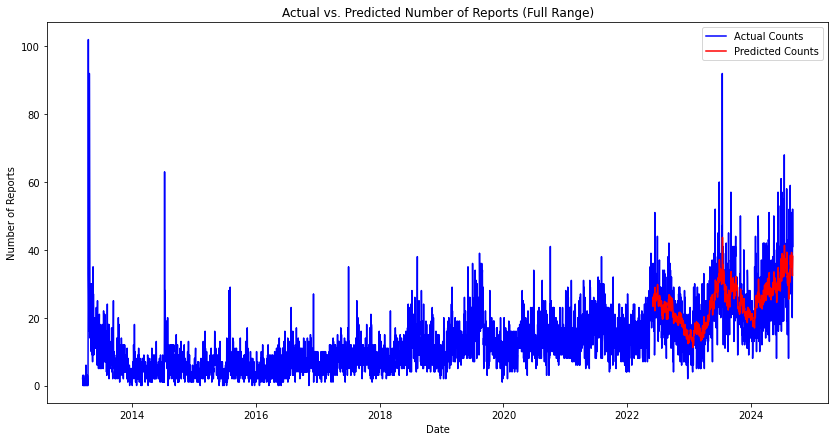

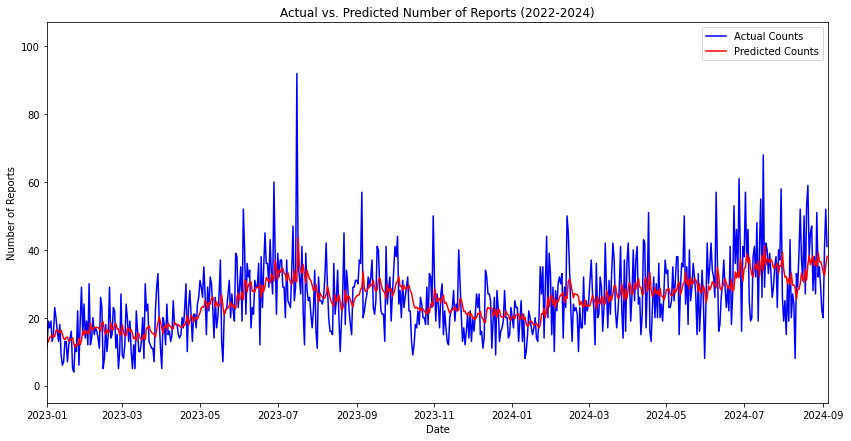

In [97]:
plt.figure(figsize=(14, 7))

# Plot actual counts
plt.plot(df_daily_counts['date'], df_daily_counts['count'], label='Actual Counts', color='blue')

# Plot predicted counts
plt.plot(result_df['date'], result_df['predicted_number_of_reports'], label='Predicted Counts', color='red')

# Add title and labels
plt.title('Actual vs. Predicted Number of Reports (Full Range)')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.legend()
#plt.savefig('Forecast_2013_2024.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Zoomed-in plot for 2022-2024
plt.figure(figsize=(14, 7))

# Plot actual counts
plt.plot(df_daily_counts['date'], df_daily_counts['count'], label='Actual Counts', color='blue')

# Plot predicted counts
plt.plot(result_df['date'], result_df['predicted_number_of_reports'], label='Predicted Counts', color='red')

# Add title and labels
plt.title('Actual vs. Predicted Number of Reports (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.legend()

# Set x-axis limits
plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-09-05'))
#plt.savefig('Forecast_2023_2024.pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [107]:
# Number of days to predict beyond the test set
n_future_days = int(6*30)  # For example, predict the next 30 days

# Create an input sequence for future prediction starting from the last test data
last_sequence = test_scaled[-sequence_length:]  # Last 'sequence_length' days from the test data

# Initialize a list to hold future predictions
future_predictions = []

# Autoregressive prediction for future days
for _ in range(n_future_days):
    # Predict the next day based on the current input sequence
    next_prediction = model.predict(last_sequence[np.newaxis, :, :])
    
    # Append the predicted value to the future predictions
    future_predictions.append(next_prediction[0, 0])
    
    # Update the input sequence for the next iteration
    # Remove the first element and append the predicted value to the end
    last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

# Inverse transform the future predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates starting from the last date in your test set
last_test_date = df_daily_counts['date'].max()
future_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=n_future_days)

# Create a DataFrame for the future predictions
future_predictions_df = pd.DataFrame({
    'date': future_dates,
    'predicted_number_of_reports': future_predictions.flatten()
})

# Concatenate the future predictions with the existing result DataFrame
extended_result_df = pd.concat([result_df, future_predictions_df], ignore_index=True)

# Display the extended predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

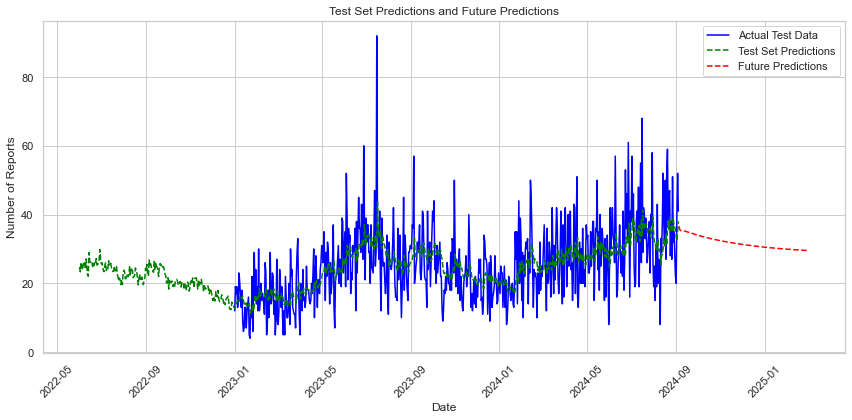

selected years ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
selected months ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
selected kreise [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
selected status ['fixed - council', 'external', 'jurisdiction unk', 'not contactable', 'wish', 'confirmed']
selected years 2 [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
<class 'plotly.graph_objs._figure.Figure'>
None


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual test data
plt.plot(df_daily_counts['date'].iloc[-len(test_data):], 
         scaler.inverse_transform(test_scaled), 
         label='Actual Test Data', color='blue')

# Plot the predictions on the test set
plt.plot(result_df['date'], 
         result_df['predicted_number_of_reports'], 
         label='Test Set Predictions', color='green', linestyle='dashed')

# Plot the future predictions
plt.plot(future_predictions_df['date'], 
         future_predictions_df['predicted_number_of_reports'], 
         label='Future Predictions', color='red', linestyle='dashed')

# Add labels and title
plt.title('Test Set Predictions and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming df_daily_counts is already defined and preprocessed

# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_daily_counts[['count']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 60  # Experiment with different lengths

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and validation sets
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

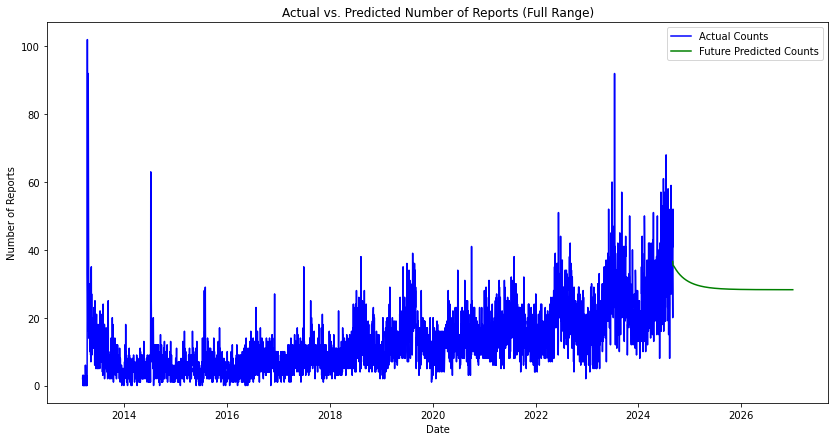

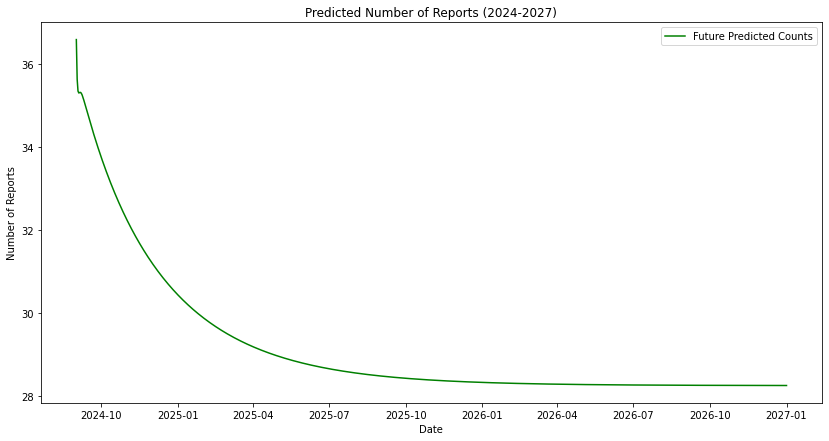

In [99]:
# Define the prediction horizon for future dates
future_dates = pd.date_range(start='2024-09-01', end='2027-01-01')

# Prepare the last sequence from the training data for prediction
last_sequence = scaled_data[-sequence_length:]

# Predict future values iteratively
future_predictions = []
current_sequence = last_sequence

for _ in range(len(future_dates)):
    prediction = model.predict(current_sequence[np.newaxis, :, :])
    future_predictions.append(prediction[0, 0])
    current_sequence = np.append(current_sequence[1:], prediction, axis=0)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create the result DataFrame for future predictions
future_result_df = pd.DataFrame({
    'date': future_dates,
    'predicted_number_of_reports': future_predictions.flatten()
})


# Full range plot
plt.figure(figsize=(14, 7))

# Plot actual counts
plt.plot(df_daily_counts['date'], df_daily_counts['count'], label='Actual Counts', color='blue')

# Plot predicted counts
plt.plot(future_result_df['date'], future_result_df['predicted_number_of_reports'], label='Future Predicted Counts', color='green')

# Add title and labels
plt.title('Actual vs. Predicted Number of Reports (Full Range)')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.legend()

# Save the plot as a PNG with tight bounding box
#plt.savefig('Forecast_2013_2024.png', bbox_inches='tight')

# Show the plot
plt.show()

# Zoomed-in plot for 2024-2027
plt.figure(figsize=(14, 7))

# Plot future predicted counts
plt.plot(future_result_df['date'], future_result_df['predicted_number_of_reports'], label='Future Predicted Counts', color='green')

# Add title and labels
plt.title('Predicted Number of Reports (2024-2027)')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.legend()

# Save the plot as a PNG with tight bounding box
#plt.savefig('Forecast_2024_2027.png', bbox_inches='tight')

# Show the plot
plt.show()

In [148]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go


# Assume 'df' is your DataFrame with columns 'requested_datetime' and 'service_name'
# Group by date to get the number of reports per day
df1 = df.copy()
df1['date'] = pd.to_datetime(df1['requested_datetime'].dt.date)  # Convert to date only
df_grouped = df1.groupby('date').size().reset_index(name='num_reports')

# Split the data into training (until 2022) and testing (2022-2024)
train_data = df_grouped[df_grouped['date'] < '2022-01-01']
test_data = df_grouped[(df_grouped['date'] >= '2022-01-01') & (df_grouped['date'] <= '2024-01-01')]

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_scaled = scaler.fit_transform(train_data[['num_reports']])
test_scaled = scaler.transform(test_data[['num_reports']])

# Function to create sequences for LSTM
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 32
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test   = create_sequences(test_scaled, sequence_length)

# Reshape input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0], X_test.shape[1], 1))



early_stopping = EarlyStopping(
    monitor='loss',             # or 'val_accuracy', depending on your metric
    patience=5,                 # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,            # Minimum change to qualify as an improvement
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
if True:
    model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=[early_stopping])


C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.0037
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0022
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0023
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0022
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0021
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0022


In [151]:

# Predict using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
# Ensure 'predictions' column is initialized
train_data.loc[:,'predictions'] = np.nan
test_data.loc[:,'predictions'] = np.nan

# Assign train predictions (ensure alignment)
train_data.loc[train_data.index[sequence_length:], 'predictions'] = train_predictions.flatten()

# Assign test predictions (ensure alignment)
test_data.loc[test_data.index[sequence_length:], 'predictions'] = test_predictions.flatten()

# Combine the dataframes for visualization
combined_df = pd.concat([train_data, test_data])

# Visualization
fig = go.Figure()

# Add actual historical data
fig.add_trace(go.Scatter(
    x=train_data['date'],
    y=train_data['num_reports'],
    mode='lines',
    name='Historical Data (Train)',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_data['date'],
    y=test_data['num_reports'],
    mode='lines',
    name='Historical Data (Test)',
    line=dict(color='green')
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=combined_df['date'],
    y=combined_df['predictions'],
    mode='lines',
    name='Forecasted Data',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Forecast of Number of Reports Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of Reports'),
    font=dict(family='Roboto'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [150]:
# Filter data from 2022-2024 for actual and predicted values
test_data_2022_2024 = test_data[test_data['date'].between('2022-01-01', '2024-12-31')]

# Initialize a figure
fig = go.Figure()

# Plot the actual data from 2022-2024
fig.add_trace(go.Scatter(
    x=test_data_2022_2024['date'],
    y=test_data_2022_2024['num_reports'],
    mode='lines+markers',
    name='Actual Data (2022-2024)',
    line=dict(color='green')
))

# Plot the predicted data from 2022-2024
fig.add_trace(go.Scatter(
    x=test_data_2022_2024['date'],
    y=test_data_2022_2024['predictions'],
    mode='lines+markers',
    name='Predicted Data (2022-2024)',
    line=dict(color='red', dash='dash')  # Dashed line for predictions
))

# Update the layout
fig.update_layout(
    title='Actual vs Predicted Reports (2022-2024)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of Reports'),
    font=dict(family='Roboto'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()
